# Explore protein sequences and structures

In [1]:
import torch
# print(torch.__version__)
# print(torch.version.cuda)
import dgl

import boto3
import gzip
import numpy as np
import pandas as pd
from io import StringIO
from sklearn.metrics import pairwise_distances
from Bio import pairwise2
from Bio.Seq import Seq
from Bio.PDB.Polypeptide import three_to_one, is_aa
from Bio.PDB import MMCIFParser

In [2]:
# custom utils
import sys
sys.path.append('lm-gvp')
from data.contact_map_utils import gunzip_to_ram
from data.prepare_GO_data import chain_to_coords

In [3]:
import matplotlib.pylab as plt
import seaborn as sns

In [4]:
def read_file_from_s3(bucket, prefix):
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket, prefix)
    return obj.get()['Body']

## 1. Get a protein structure from PDB via AWS Opendata registry

https://registry.opendata.aws/pdb-3d-structural-biology-data/

In [5]:
pdb_id = '6XWU'
pdb_bucket_name = 'pdbsnapshots'

In [6]:
# retrieve and parse a protein structure from PDB
cif_parser = MMCIFParser()

pdb_file = read_file_from_s3(
    pdb_bucket_name,
    f'20220103/pub/pdb/data/structures/all/mmCIF/{pdb_id.lower()}.cif.gz'
)
structure = cif_parser.get_structure(pdb_id, gunzip_to_ram(pdb_file))

In [7]:
print(structure, type(structure))

<Structure id=6XWU> <class 'Bio.PDB.Structure.Structure'>


In [8]:
def extract_coords(structure, target_atoms=["N", "CA", "C", "O"]):
    '''
    Extract the atomic coordinates for all the chains.
    '''
    records = []
    chain_ids = set()
    for chain in structure.get_chains():
        if chain.id in chain_ids:  # skip duplicated chains
            continue
        chain_ids.add(chain.id)
        record = chain_to_coords(chain, 
                                 name=structure.id, 
                                 target_atoms=target_atoms)
        if record is not None:
            records.append(record)
    return records

In [9]:
records = extract_coords(structure)
# take the first chain from the structure
protein = records[0]
print(protein['seq'])
print('sequence length:', len(protein['seq']))

DEQEEASTKLMQWLRGVGDAPPSASMSDENASVSSANELIFYQVDGIDYAFYNTKEKAMLGYMRFKPYQKRSMKQAKVHPLKLLVQFGEFNVETLAVGEEKEVHSVLRVGDMIEIDRGTRYSIQNAIDKVSVLMCIRS
sequence length: 138


In [10]:
# 3d coordinates of 4 key atoms ["N", "CA", "C", "O"]
coords = np.asarray(protein['coords']) 
print(coords.shape)

(138, 4, 3)


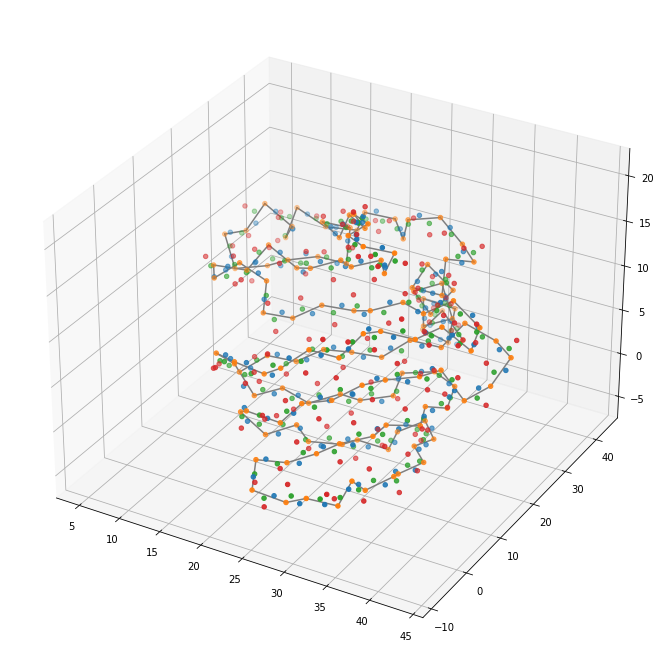

In [11]:
# Visualize 4 key atoms across amino acid residues in the protein
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

colors = sns.color_palette()
atoms = ["N", "CA", "C", "O"]
for i, atom in enumerate(atoms):
    ax.scatter(coords[:, i, 0],
               coords[:, i, 1],
               coords[:, i, 2],
               color=colors[i]
              );
    
# connect CA atoms sequentially
coords_CA = coords[:, 1]
N_residues = coords.shape[0]
edge_pos = np.array([(coords_CA[u], coords_CA[u+1]) for u in range(N_residues-1)])

# Plot the edges
for vizedge in edge_pos:
    ax.plot(*vizedge.T, color="tab:gray")

(138, 138)


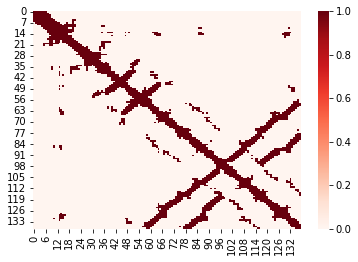

In [12]:
# Visualize as contact map
# calculate adjacency matrix of residues by proximity threshod
dist_thresh = 10.0
dist_mat = pairwise_distances(coords_CA, metric="euclidean")
adj =  1 * (dist_mat < dist_thresh)
print(adj.shape)
sns.heatmap(adj, cmap='Reds');

(138, 138)


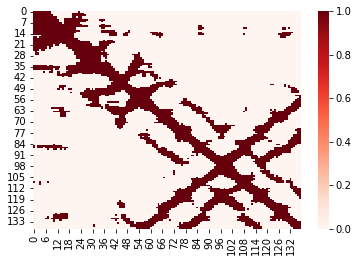

In [13]:
# alternatively, build a kNN graph
g = dgl.knn_graph(torch.tensor(coords_CA), k=30)
adj = g.adj(scipy_fmt='coo')
print(adj.shape)
sns.heatmap(adj.todense(), cmap='Reds');

## 2. Compute contextual embeddings for protein sequence from pretrained protein language model

In [16]:
from transformers import BertTokenizer, AlbertModel

In [17]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
prot_lm = AlbertModel.from_pretrained('Rostlab/prot_albert')

Some weights of the model checkpoint at Rostlab/prot_albert were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.dense.bias', 'predictions.bias', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.bias', 'sop_classifier.classifier.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
import re
def prep_seq(seq):
    """
    Adding spaces between AAs and replace rare AA [UZOB] to X.
    ref: https://huggingface.co/Rostlab/prot_bert.
    """
    seq_spaced = " ".join(seq)
    seq_input = re.sub(r"[UZOB]", "X", seq_spaced)
    return seq_input

In [19]:
encodings = tokenizer(prep_seq(protein['seq']), 
                      return_tensors="pt", 
                      padding=True)
encodings

{'input_ids': tensor([[ 2, 14,  9, 18,  9,  9,  6, 10, 15, 12,  5, 21, 18, 24,  5, 13,  7,  8,
          7, 14,  6, 16, 16, 10,  6, 10, 21, 10, 14,  9, 17,  6, 10,  8, 10, 10,
          6, 17,  9,  5, 11, 19, 20, 18,  8, 14,  7, 11, 14, 20,  6, 19, 20, 17,
         15, 12,  9, 12,  6, 21,  5,  7, 20, 21, 13, 19, 12, 16, 20, 18, 12, 13,
         10, 21, 12, 18,  6, 12,  8, 22, 16,  5, 12,  5,  5,  8, 18, 19,  7,  9,
         19, 17,  8,  9, 15,  5,  6,  8,  7,  9,  9, 12,  9,  8, 22, 10,  8,  5,
         13,  8,  7, 14, 21, 11,  9, 11, 14, 13,  7, 15, 13, 20, 10, 11, 18, 17,
          6, 11, 14, 12,  8, 10,  8,  5, 21, 23, 11, 13, 10,  3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         

In [20]:
device = torch.device('cuda:0')
prot_lm = prot_lm.to(device)

In [21]:
prot_lm.eval()

AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(34, 128, padding_idx=0)
    (position_embeddings): Embedding(40000, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=4096, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((4096,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertAttention(
              (query): Linear(in_features=4096, out_features=4096, bias=True)
              (key): Linear(in_features=4096, out_features=4096, bias=True)
              (value): Linear(in_features=4096, out_features=4096, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False)

In [22]:
# skip [CLS] and [SEP]
residue_embeddings = prot_lm(encodings['input_ids'].to(device))\
    .last_hidden_state[:, 1:-1, :]
print(residue_embeddings.shape)

torch.Size([1, 138, 4096])


## 3. Generate additional features for a protein

- Edges
    + vector features: edge vectors
    + scalar features: RBF of edge vectors    
- Nodes
    + vector features
    + scalar features

In [23]:
# construct knn graph from C-alpha coordinates
coords_CA = torch.tensor(coords_CA)
g = dgl.knn_graph(coords_CA, k=30)
edge_index = g.edges()
g

Graph(num_nodes=138, num_edges=4140,
      ndata_schemes={}
      edata_schemes={})

In [24]:
# Directions along edges between adjacent C-alpha atoms
E_vectors = coords_CA[edge_index[0]] - coords_CA[edge_index[1]]
E_vectors.shape

torch.Size([4140, 3])

In [25]:
import math
import torch.nn.functional as F

def get_rbf(D, D_min=0.0, D_max=20.0, D_count=16, device="cpu"):
    """
    From https://github.com/jingraham/neurips19-graph-protein-design

    Returns an RBF embedding of `torch.Tensor` `D` along a new axis=-1.
    That is, if `D` has shape [...dims], then the returned tensor will have
    shape [...dims, D_count].


    Args:
        D: generic torch tensor
        D_min: Float. Minimum of the sequence of numbers created.
        D_max: Float. Max of the sequence of numbers created.
        D_count: Positive integer. Count of the numbers in the sequence. It is also lenght of the new dimension (-1) created in D.
        device: Device where D is stored.

    Return:
        Input `D` matrix with an RBF embedding along axis -1.
    """
    D_mu = torch.linspace(D_min, D_max, D_count, device=device)
    D_mu = D_mu.view([1, -1])
    D_sigma = (D_max - D_min) / D_count
    D_expand = torch.unsqueeze(D, -1)

    RBF = torch.exp(-(((D_expand - D_mu) / D_sigma) ** 2))
    return RBF

In [26]:
# RBF embeddings of the edge vectors as edge scalar features
rbf_E_vectors = get_rbf(E_vectors.norm(dim=-1), D_count=16)
rbf_E_vectors.shape

torch.Size([4140, 16])

In [27]:
def _normalize(tensor, dim=-1):
    """
    Normalizes a `torch.Tensor` along dimension `dim` without `nan`s.
    """
    return torch.nan_to_num(
        torch.div(tensor, torch.norm(tensor, dim=dim, keepdim=True))
    )

def get_dihedrals(X, eps=1e-7):
    """Compute sines and cosines dihedral angles (phi, psi, and omega)

    Args:
        X: torch.Tensor specifying coordinates of key atoms (N, CA, C, O) in 3D space with shape [seq_len, 4, 3]
        eps: Float defining the epsilon using to clamp the angle between normals: min= -1*eps, max=1-eps

    Returns:
        Sines and cosines dihedral angles as a torch.Tensor of shape [seq_len, 6]
    """
    # From https://github.com/jingraham/neurips19-graph-protein-design
    X = torch.reshape(X[:, :3], [3 * X.shape[0], 3])
    dX = X[1:] - X[:-1]
    U = _normalize(dX, dim=-1)
    u_2 = U[:-2]
    u_1 = U[1:-1]
    u_0 = U[2:]

    # Backbone normals
    n_2 = _normalize(torch.cross(u_2, u_1), dim=-1)
    n_1 = _normalize(torch.cross(u_1, u_0), dim=-1)

    # Angle between normals
    cosD = torch.sum(n_2 * n_1, -1)
    cosD = torch.clamp(cosD, -1 + eps, 1 - eps)
    D = torch.sign(torch.sum(u_2 * n_1, -1)) * torch.acos(cosD)

    # This scheme will remove phi[0], psi[-1], omega[-1]
    D = F.pad(D, [1, 2])
    D = torch.reshape(D, [-1, 3])
    # Lift angle representations to the circle
    D_features = torch.cat([torch.cos(D), torch.sin(D)], 1)
    return D_features

In [28]:
# Dihedral angles as node scalar features
dihedrals = get_dihedrals(torch.tensor(coords))
dihedrals.shape

torch.Size([138, 6])

In [29]:
def get_orientations(X):
    """Compute orientations between pairs of atoms from neighboring residues.

    Args:
        X: torch.Tensor representing atom coordinates with shape [n_atoms, 3]

    Returns:
        torch.Tensor atom pair orientations
    """
    forward = _normalize(X[1:] - X[:-1])
    backward = _normalize(X[:-1] - X[1:])
    forward = F.pad(forward, [0, 0, 0, 1])
    backward = F.pad(backward, [0, 0, 1, 0])
    return torch.cat([forward.unsqueeze(-2), backward.unsqueeze(-2)], -2)

def get_sidechains(X):
    """Compute the unit vector representing the imputed side chain directions (C_beta - C_alpha).

    Args:
        X: torch.Tensor specifying coordinates of key atoms (N, CA, C, O) in 3D space with shape [seq_len, 4, 3]

    Returns:
        Torch tensor representing side chain directions with shape [seq_len, 3]
    """
    n, origin, c = X[:, 0], X[:, 1], X[:, 2]
    c, n = _normalize(c - origin), _normalize(n - origin)
    bisector = _normalize(c + n)
    perp = _normalize(torch.cross(c, n))
    vec = -bisector * math.sqrt(1 / 3) - perp * math.sqrt(2 / 3)
    return vec

In [30]:
# Orientations, side chains as node vector features
orientations = get_orientations(coords_CA)
print(orientations.shape)
sidechains = get_sidechains(torch.tensor(coords))
print(sidechains.shape)

torch.Size([138, 2, 3])
torch.Size([138, 3])


In [31]:
coords_CA.shape

torch.Size([138, 3])

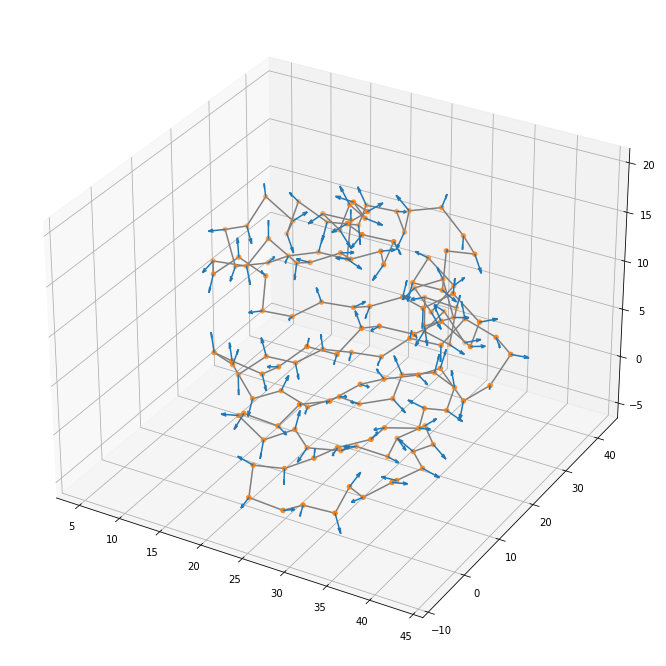

In [32]:
# plot the side chain vector feature as a 3d vector field
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

atoms = ["N", "CA", "C", "O"]
i = 1
ax.scatter(coords[:, i, 0],
           coords[:, i, 1],
           coords[:, i, 2],
           color=colors[i]
          );
    
# # connect CA atoms sequentially
coords_CA = coords[:, 1]
N_residues = coords.shape[0]
edge_pos = np.array([(coords_CA[u], coords_CA[u+1]) for u in range(N_residues-1)])

# Plot the edges
for vizedge in edge_pos:
    ax.plot(*vizedge.T, color="tab:gray")
    
# plot the directions of side chains for each node (amino acid residue)
ax.quiver(coords_CA[:, 0], 
          coords_CA[:, 1],
          coords_CA[:, 2],
          sidechains[:, 0],
          sidechains[:, 1],
          sidechains[:, 2],
          length=2, 
          normalize=True
         )

## 4. Examine the protein function dataset

The training dataset is 10% randomly sampled subset of the original data used in the LM-GVP paper. 

In [33]:
import json

In [34]:
!aws s3 cp s3://gnn-in-lifesci-kdd2022/DeepFRI_GO_data/ protein_data/DeepFRI_GO --recursive

download: s3://gnn-in-lifesci-kdd2022/DeepFRI_GO_data/nrPDB-GO_2019.06.18_annot.tsv to protein_data/DeepFRI_GO/nrPDB-GO_2019.06.18_annot.tsv
download: s3://gnn-in-lifesci-kdd2022/DeepFRI_GO_data/proteins_train.json to protein_data/DeepFRI_GO/proteins_train.json
download: s3://gnn-in-lifesci-kdd2022/DeepFRI_GO_data/proteins_valid.json to protein_data/DeepFRI_GO/proteins_valid.json
download: s3://gnn-in-lifesci-kdd2022/DeepFRI_GO_data/proteins_test.json to protein_data/DeepFRI_GO/proteins_test.json


In [35]:
# s3://gnn-in-lifesci-kdd2022/DeepFRI_GO_data/
bucket = 'gnn-in-lifesci-kdd2022'
train_data = json.load(
    read_file_from_s3(bucket, 'DeepFRI_GO_data/proteins_train.json')
)

In [36]:
N_train = len(train_data)
print('Number of proteins in training set:', N_train)

# examine a protein instance
protein = train_data[0]
print(protein.keys())
print('name:', protein['name'])
print('seq:', protein['seq'])
print('coords.shape:', np.asarray(protein['coords']).shape)

Number of proteins in training set: 2990
dict_keys(['seq', 'coords', 'name'])
name: 2Q9Q-C
seq: MFCEKAMELIRELHRAPEGQLPAFNEDGLRQVLEEMKALYEQNQSDVNEAKSGGRSDLIPTIKFRHCSLLRNRRCTVAYLYDRLLRIRALRWEYGSILPNALRFHMAAEEMEWFNNYKRSLATYMRSLGGDEGLDITQDMKPPKS
coords.shape: (145, 4, 3)


In [37]:
# sample_idx = np.random.choice(N_train, int(0.1*N_train))
# train_data_sample = [train_data[idx] for idx in sample_idx]
# len(train_data_sample)

In [38]:
# json.dump(train_data_sample, open('proteins_train.json', 'w'))

In [39]:
from lmgvp.deepfrier_utils import load_GO_annot

In [40]:
# !aws s3 cp s3://gnn-in-lifesci-kdd2022/DeepFRI_GO_data/nrPDB-GO_2019.06.18_annot.tsv .

In [41]:
prot2annot, goterms, gonames, counts = load_GO_annot(
    'DeepFRI_GO_data/nrPDB-GO_2019.06.18_annot.tsv'
)

In [42]:
for key, terms in goterms.items():
    print(key, len(terms))

mf 489
bp 1943
cc 320


In [43]:
for key, terms in counts.items():
    print(key, len(terms))

mf 489
bp 1943
cc 320


In [44]:
go_cc_meta = pd.DataFrame({
    'term': goterms['cc'],
    'name': gonames['cc'],
    'protein_counts': counts['cc']                          
}).set_index('term')
go_cc_meta.sort_values('protein_counts', ascending=False).head()

,name,protein_counts
term,,
GO:0005829,cytosol,3754.0
GO:0043228,non-membrane-bounded organelle,3743.0
GO:0043232,intracellular non-membrane-bounded organelle,3682.0
GO:0005634,nucleus,3463.0
GO:0071944,cell periphery,2625.0
